# Results Notebook 

This is the notebook, where we collect all results after running the agents across 20 different seeds. 
Given that the episode statistics are quite large, we extract all data and pickle it seperately to ensure a fast aggregation. 

To replicate the Episode Statistics, you have to rerun the scripts on the validation environment of the 2022 WCCI environment. 

In [1]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import random
import pickle
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 5]
import plotly
import plotly.express as px
import grid2op
from lightsim2grid import LightSimBackend
EVALUATION_PATH = Path("/share/data1/GYM/seed_hugo_parallel/")
env = grid2op.make('l2rpn_wcci_2022')


/share/data1/GYM/anaconda3/envs/py310/lib/python3.10/site-packages/lightsim2grid/securityAnalysis.py:76: FutureWarning: In the future `np.str` will be defined as the corresponding NumPy scalar.
  STR_TYPES = (str, np.str, np.str_)
numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)

numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)

numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)



In [2]:
obs = env.reset()
print(len(obs.to_vect()))

numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)



4295


In [3]:
print(f"Line Action Space {len(env.action_space.get_all_unitary_line_change(env.action_space))}")
print(f"Bus Action Space {len(env.action_space.get_all_unitary_topologies_set(env.action_space))}")
print(f"Redispace Action Space {len(env.action_space.get_all_unitary_redispatch(env.action_space))}")
print(f"Storage Action Space {len(env.action_space.get_all_unitary_storage(env.action_space))}")
print(f"Alarm Action Space {len(env.action_space.get_all_unitary_alarm(env.action_space))}")

Line Action Space 186
Bus Action Space 72957
Redispace Action Space 160
Storage Action Space 56
Alarm Action Space 0


In [4]:
env.action_space.get_all_unitary_storage(env.action_space)[3].as_dict()

{'storage_power': array([12.,  0.,  0.,  0.,  0.,  0.,  0.], dtype=float32)}

# Results of 20 seeds

We collect the results of the 20 seeds. Not that the batch script and the python script can be fund under ```seeds_hugo2.sh``` and ```get_seed_hugo_parallel2.py```. Further, note that we did a minor modification in grid2op to ensure parallel execution with tensorflow. 

In [28]:
# Seeting Seeds: 
np.random.seed(8888)
seeds = list(np.random.randint(0, 10000,20))
print(seeds)

# Provide Names 
agent_names = ["DoNothing","Senior_original_95","Topo_Agent_95","Senior_original_85"] #
plotting_names = {"Topo_Agent_95_2":"Topology Agent","Topo_Agent_95":"Topology Agent",'Senior_original_95':'Senior 95%','Senior_original_85':'Senior 85%',"DoNothing":"DoNothing",'Senior_original_85_r':'Senior 85%',}

# Variables: 
plotting = True # Set this to true, to generate the plots
execution = False # Set this to true, to rerun all collection methods (path needs to be known) 

[4483, 2120, 6825, 5612, 2224, 4735, 1016, 3891, 2377, 4582, 3484, 2015, 1501, 6987, 7768, 5229, 2069, 7503, 2809, 5715]


In [6]:
# Load and save all results in one dictionary for later plotting and easier access for other researchers:
if execution:
    total_res = {}
    for agent in ["DoNothing","Senior_original_95","Topo_Agent_95_2","Senior_original_85_r"]:
        total_seed_res = {}
        for s in seeds:
            file_name = EVALUATION_PATH  / str(s) / (agent+"_report_data.pkl")
            if Path(file_name).is_file():
                with open(file_name, "rb") as fp:   
                    res = pickle.load(fp)
                total_seed_res[s] = res
    
        # Change experiment names for plotting/Tables             
        if agent == "Topo_Agent_95_2":
            agent = "Topo_Agent_95"
        if agent == "Senior_original_85_r": 
            agent = "Senior_original_85"
        total_res[agent] = total_seed_res

    with open('res.pkl', 'wb') as handle:
        pickle.dump(total_res, handle, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open('res.pkl', 'rb') as handle:
        total_res = pickle.load(handle)

2024-05-17 13:49:26.666436: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-17 13:49:30.212808: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [7]:
agent_scores = {}
total_scores = {}
total_surv = {}
runntime = {}
for agent in agent_names:
    res_seed = []
    scores_seed = []
    tot_scors = []
    run_t = []
    # Go through seeds:
    for s in seeds:
        if s in total_res[agent].keys():
            res = total_res[agent][s]
          
            res_seed.append(np.array(res.score_data["ts_survived"]))
            tot_scors.append(res.score_data['all_scores'])
            scores_seed.append(res.avg_score)
            run_t.append(res.evaluation_time)
        else:
            scores_seed.append(np.nan)
    
    agent_scores[agent] = scores_seed
    total_surv[agent] = res_seed
    total_scores[agent] = tot_scors
    runntime[agent] = run_t

#### One Agent reports looks like the following: 

We have name, score data, the time steps survived as well as the scenario names 

## Score across seeds
Now let's look at the score accross all seeds

In [8]:
seed_res = pd.DataFrame(agent_scores,index = seeds)
print(seed_res.mean(axis=0))
seed_res

DoNothing              0.000000
Senior_original_95    37.133539
Topo_Agent_95         41.264876
Senior_original_85    33.068733
dtype: float64


,DoNothing,Senior_original_95,Topo_Agent_95,Senior_original_85
4483,0.0,37.416851,36.647422,33.376420
2120,0.0,40.595625,43.521050,36.718437
6825,0.0,32.506190,39.822362,30.797467
5612,0.0,37.507430,44.590938,38.596329
2224,0.0,31.986719,39.715606,32.684211
4735,0.0,33.801222,41.744456,33.721225
1016,0.0,42.198918,43.290341,36.974264
3891,0.0,29.854486,36.991928,24.447490
2377,0.0,43.615669,46.486550,39.781458
4582,0.0,31.847255,38.436412,29.874893


In [9]:
out = seed_res.describe().round(2)
out
# out.to_latex()

,DoNothing,Senior_original_95,Topo_Agent_95,Senior_original_85
count,20.0,20.00,20.00,20.00
mean,0.0,37.13,41.26,33.07
std,0.0,4.49,3.01,3.85
min,0.0,29.85,36.65,24.45
25%,0.0,33.48,39.41,30.72
50%,0.0,37.21,40.41,32.38
75%,0.0,39.84,43.69,36.59
max,0.0,46.51,46.49,39.78


In [10]:
increase = ((out["Topo_Agent_95"]["mean"]/out["Senior_original_95"]["mean"] -1 )*100).round(0)
print(f" The Topo agent achieved a {increase }% increase in the score")

 The Topo agent achieved a 11.0% increase in the score


## Let's examine the run time of each agent 

In [11]:
for k,v in runntime.items():
    print(f" The run time of agent {k} was on average {np.mean(v)}")

 The run time of agent DoNothing was on average 3910.4085933926517
 The run time of agent Senior_original_95 was on average 6556.719552968175
 The run time of agent Topo_Agent_95 was on average 7931.25987119638
 The run time of agent Senior_original_85 was on average 43564.210457384776


## Next, we look at the survival time. 

Here, we look specifically at the median for each scenario (total of 52) 

In [12]:
idx_ts = [pd.Timestamp(t[:10]).strftime('%b-%d') for t in res.score_data["episode_name"]]

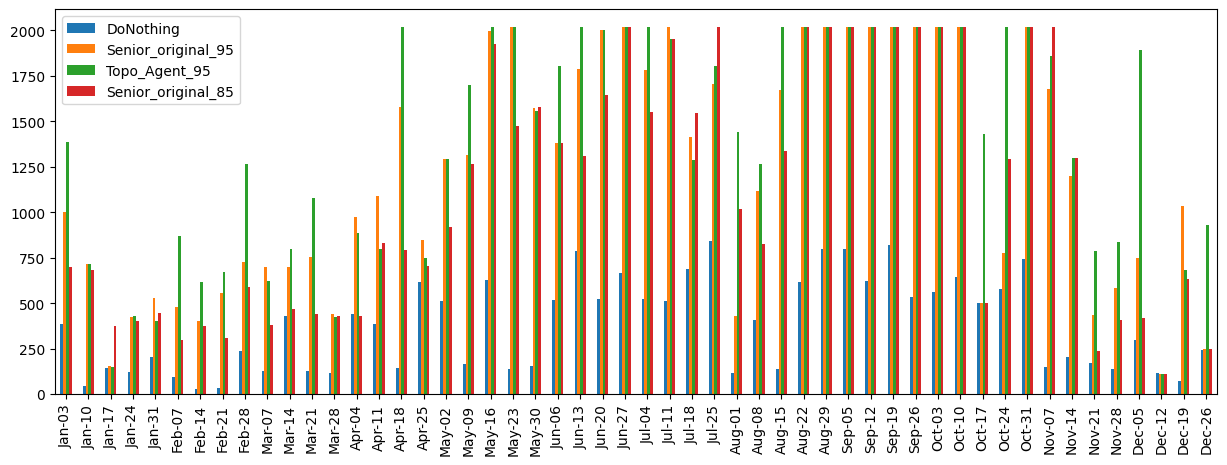

In [13]:
surv_df = pd.DataFrame({a:np.median(np.vstack(v),axis=0) for a,v in total_surv.items()},index =idx_ts )
surv_df.plot.bar()
median_overal_survival = pd.Series({k:np.median(v) for k,v in total_surv.items()})

In [14]:
median_overal_survival

DoNothing              229.0
Senior_original_95     988.0
Topo_Agent_95         1232.0
Senior_original_85     806.0
dtype: float64

In [15]:
increase = ((median_overal_survival["Topo_Agent_95"]/median_overal_survival["Senior_original_95"] -1 )*100).round()
print(f" The Topo agent achieved a {increase }% increase in the median survival ")

 The Topo agent achieved a 25.0% increase in the median survival 


In [16]:
(surv_df==2017.0).sum(axis=0)

DoNothing              0
Senior_original_95    12
Topo_Agent_95         17
Senior_original_85    12
dtype: int64

In [17]:
out2 = surv_df.describe().round(0)
out2
#out2.to_latex()

,DoNothing,Senior_original_95,Topo_Agent_95,Senior_original_85
count,52.0,52.0,52.0,52.0
mean,376.0,1213.0,1386.0,1110.0
std,253.0,647.0,621.0,677.0
min,30.0,112.0,112.0,112.0
25%,138.0,668.0,798.0,437.0
50%,383.0,1160.0,1436.0,968.0
75%,588.0,2000.0,2017.0,1933.0
max,840.0,2017.0,2017.0,2017.0


# Testing for Significance

In [18]:
# D’Agostino and Pearson’s Test for normality with H_0: X ~N(mu,sigma)
from scipy import stats

In [19]:
# D’Agostino and Pearson’s Test for normality with H_0: X ~N(mu,sigma)
test_df =  seed_res.copy()
from scipy import stats
print("Checking for normality\n")
for k in  test_df.columns: 
    k2, p = stats.normaltest(test_df[k])
    print(f"The results of {k} have a p-value of {p} to be normal distributed")

Checking for normality

The results of DoNothing have a p-value of nan to be normal distributed
The results of Senior_original_95 have a p-value of 0.9115099240394666 to be normal distributed
The results of Topo_Agent_95 have a p-value of 0.2518259264007935 to be normal distributed
The results of Senior_original_85 have a p-value of 0.9799770821706967 to be normal distributed


In [20]:
# "DoNothing","Senior_original_95","Topo_Agent_95",

test_c = [["DoNothing","Senior_original_95"],["DoNothing","Topo_Agent_95"] ,["Senior_original_95","Topo_Agent_95"],["Senior_original_85","Topo_Agent_95"]]

alpha = 0.05
res_dict= {}

for test_obj in test_c:
    k2,p = stats.ttest_ind(test_df[test_obj[0]], test_df[test_obj[1]], equal_var=False, alternative='two-sided')
    if p < alpha: 
        out = f"We reject the H_0 hypothesis with a p-value of {p} and an alpha of {alpha}"
    else:
        out = f"We can not reject the H_0 hypothesis with a p-value of {p} and an alpha of {alpha}"
    
    print(f"Testing, whether the {test_obj[0]} and the {test_obj[1]} agent are from the same distribution. \n-> {out}")
    print()
    res_dict[test_obj[0]+" vs. "+test_obj[1]] = p

Testing, whether the DoNothing and the Senior_original_95 agent are from the same distribution. 
-> We reject the H_0 hypothesis with a p-value of 3.6095612041936917e-19 and an alpha of 0.05

Testing, whether the DoNothing and the Topo_Agent_95 agent are from the same distribution. 
-> We reject the H_0 hypothesis with a p-value of 2.5986615891774415e-23 and an alpha of 0.05

Testing, whether the Senior_original_95 and the Topo_Agent_95 agent are from the same distribution. 
-> We reject the H_0 hypothesis with a p-value of 0.0016806972161764434 and an alpha of 0.05

Testing, whether the Senior_original_85 and the Topo_Agent_95 agent are from the same distribution. 
-> We reject the H_0 hypothesis with a p-value of 7.4239952626354065e-09 and an alpha of 0.05



# Plotting: 

Lastly, we plot all the results as pdfs for the paper. 

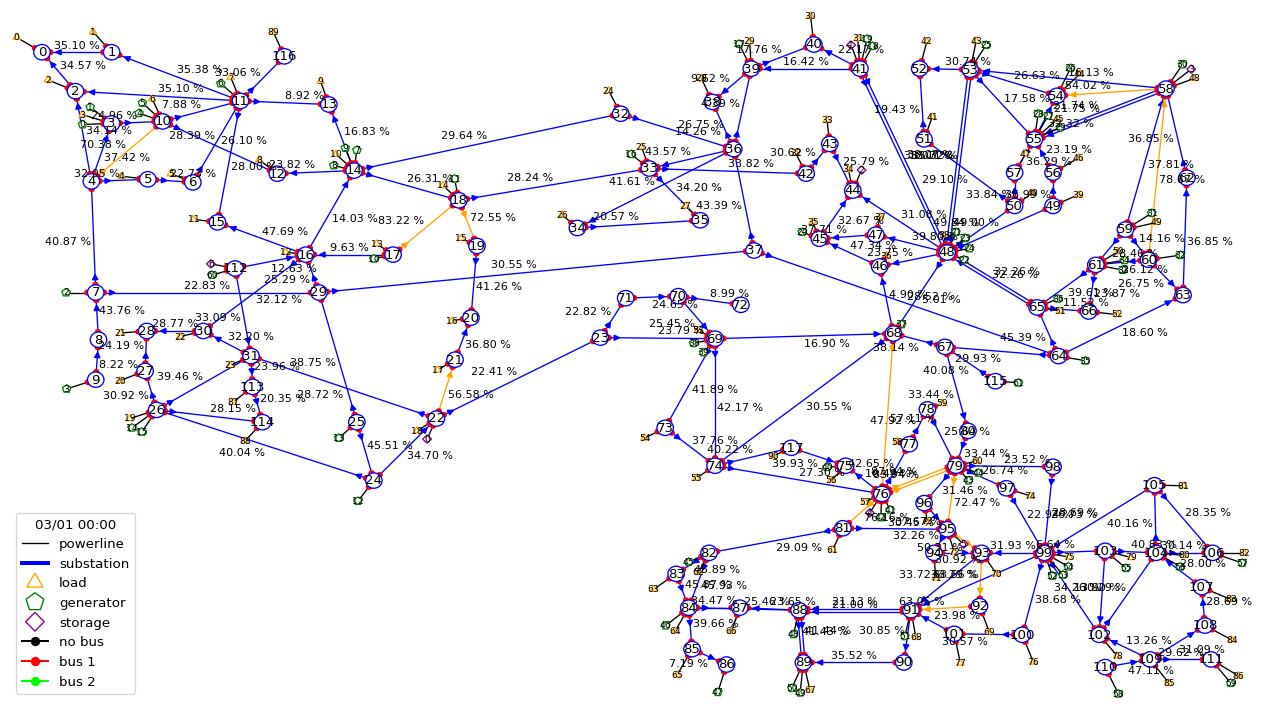

In [21]:
if plotting:
    # Survival
    score_sub = surv_df.reset_index()
    score_sub.columns = ["episode_name",
                         f"DoNothing: {int(out2['DoNothing']['50%'])} MSTCM",
                         f"Senior 95%: {int(out2['Senior_original_95']['50%'])} MSTCM",
                         f"Topology Agent: {int(out2['Topo_Agent_95']['50%'])} MSTCM",
                         f"Senior 85%: {int(out2['Senior_original_85']['50%'])} MSTCM",
                         ]
    legends =list(score_sub.columns[1:])
    legends.reverse()
    
    fig = px.bar(score_sub, x="episode_name", y=legends, title="",barmode='group',
                 template="plotly_white", width = 1000, height = 300#,
                )

    fig.update_layout(xaxis={'rangeslider': {'visible': False}}, 
                      xaxis_title='Episode Name', yaxis_title='Median time steps survived', xaxis_tickangle=-45)
    fig.update_layout(legend=dict(
        title="",
        orientation="h",
        entrywidth=350,
        yanchor="bottom",
        y=1.02,
        xanchor="left",
        x=0.0
    ))
    fig.write_image("Survial_time.pdf")
    
    # Environment of Grid2Op
    from grid2op.PlotGrid import PlotMatplot
    plot_helper = PlotMatplot(env.observation_space)
    fig = plot_helper.plot_obs(obs,storage_info=None,gen_info=None,load_info=None)
    fig.savefig(f"Grid wcci2022.pdf")
    

In [22]:
if plotting:
    if execution:
        from grid2bench.AgentsAnalytics import AgentsAnalytics
        # Addjusted AgentsAnalytics from Grid2Bench to load the agent data such as computation time and 
        # action set 
        # This will take a long time. That's why we pickled the results and only look at one seed. 
        # However, here is the code how you can execute it yourself:
        np.random.seed(8888)
        example_seed = np.random.choice(seeds)
        print(example_seed)
        # Get Agent analytics for computation time (this takes time) 
        agents = AgentsAnalytics(data_path=EVALUATION_PATH /str(example_seed) / "agent_logs",agents_names=["DoNothing","Senior_original_95","Topo_Agent_95","Senior_original_85_r"])
        computation = []
        for agent in agents.agents_data:
            df = agent.computation_times_several_episodes().copy()
            df.set_index("Timestamp",inplace=True)
            n= plotting_names[agent.agent_name]
            df.columns = [n]
            df = df[~df.index.duplicated(keep='first')]
            computation.append(df)

        comb_df = pd.concat(computation,axis=1).dropna()
        comb_df.reset_index(inplace=True)
        with open('computation_time.pkl', 'wb') as handle:
            pickle.dump(comb_df, handle, protocol=pickle.HIGHEST_PROTOCOL)
    else:
        with open('computation_time.pkl', 'rb') as handle:
            comb_df = pickle.load(handle)
            
    
    # Plot of computation time 
    order = ['Timestamp',  'Senior 85%' ,'Senior 95%', 'Topology Agent',
           'DoNothing']
    fig = px.scatter(comb_df[order], x="Timestamp", y=order[1:], marginal_y="rug",template="plotly_white",
                    labels={
                         "value": "Execution Time (in s)",
                         "Timestamp": "Grid2Op Scenarios",
                         "variable": ""
                     },width = 500,height=500) #width = 500,height=500
    fig.update_layout(xaxis = {'anchor': 'y', 'domain': [0.0, 0.65], 'title': {'text': 'Grid2Op Scenarios'},
                              "dtick":"M4","tickformat":"%b\n%Y"
                              },
                      xaxis2 =  {'anchor': 'y2','domain': [0.7, 1.0],'matches': 'x2','showgrid': False,'showline': False,'showticklabels': True,"tickangle":60,
                                 'tickmode' :  'array',"tickvals" : list(order[1:]),
                                 "ticktext" : order[1:], 'title': {'text': '\n Frequency'}, 
                                "ticklabelposition": "outside right"},     
                      yaxis2 = {'anchor': 'x2', 'domain': [0.0, 1.0], 'matches': 'y','showgrid': False, 'showline': True, 'showticklabels': False})
    
    fig.update_layout(legend=dict(
        title="",
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="left",
        x=0.0
    ))
    fig.write_image("Computation_time_short.pdf")
    
    
    # Plott run time: 
        # Run Time of agents 
    run_time = [pd.DataFrame({"Run Time" : np.array(runntime[k]),
                          "Agents" : np.repeat(plotting_names[k],20)},index = np.arange(20)) for k in [ 'Senior_original_85','Senior_original_95', 'Topo_Agent_95','DoNothing'] ]
    run_time = pd.concat(run_time,axis=0)
    fig = px.box(run_time ,x="Agents",y="Run Time",template="plotly_white", points="all",
                 color="Agents", 
                    labels={
                         "Run Time": "Execution Time per Seed (in s)",
                         "Agents": "Agents",
                         "variable": ""
                     },width = 500,height=500) #width = 350,height=500
    fig.update_xaxes(tickangle=60)
    fig.update_layout(legend=dict(
        title="",
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="left",
        x=0.0, #-1
        font_size=10
    ))
    fig.write_image("Runtime_seeds.pdf")

5612


100%|██████████| 52/52 [03:34<00:00,  4.13s/it]


# Now let's look a bit more into the Target Topologies 

For this, we run through the episode data and extract both a count of topo changes as well as the Grid Topology for each time step 

In [23]:
# Now load topologies and compare: 
topos = np.load("/share/data1/GYM/junior/wcci2022_topo/topologies_only.npy")

episode_names = ['2050-01-03_5', '2050-01-10_5', '2050-01-17_5', '2050-01-24_18', '2050-01-31_1', '2050-02-07_3', '2050-02-21_1', '2050-02-14_5', '2050-03-07_5', '2050-03-21_5', '2050-04-04_18', '2050-03-14_6', '2050-04-11_5', '2050-03-28_5',
                 '2050-02-28_5', '2050-05-16_5', '2050-05-02_5', '2050-04-18_5', '2050-05-09_11', '2050-04-25_5', '2050-06-06_16', '2050-09-26_4', '2050-08-01_5', '2050-06-27_5', '2050-08-08_5', '2050-06-13_17', '2050-07-25_8',
                 '2050-12-12_5', '2050-09-12_5', '2050-10-24_5', '2050-10-03_17', '2050-11-14_5', '2050-08-15_7', '2050-05-30_5', '2050-07-04_5', '2050-11-21_5', '2050-12-26_5', '2050-08-29_5', '2050-06-20_11', '2050-09-19_5',
                 '2050-11-07_5', '2050-10-17_5', '2050-09-05_6', '2050-08-22_14', '2050-10-31_7', '2050-05-23_1', '2050-10-10_5', '2050-07-18_5', '2050-12-19_5', '2050-12-05_9', '2050-07-11_5', '2050-11-28_5']

In [ ]:
import time
# Collect the episode data (this might take multiple hours) 
obs = env.reset()
base_topo = obs.topo_vect.copy()

if execution: 
    records = {}
    for a in ["Topo_Agent_95_2",'Senior_original_95','Senior_original_85_r']: #
        start = time.time()
        topo_records = np.hstack((0, obs.topo_vect)).reshape(1,-1)
        total_counts = []
        length_of_eps = []
        obs = env.reset()
        for s in seeds:
            for e in episode_names:
                obz = np.load(Path(f"/share/data1/GYM/seed_hugo_parallel/{s}/agent_logs/{a}/{e}/observations.npz"))
                current_topo_vect = env.observation_space.from_vect(obz["data"][0]).topo_vect
                count = 0
                length_of_eps.append(np.sum(~np.any(np.isnan(obz["data"]),axis=1)))

                for o in obz["data"]:
                    if not np.any(np.isnan(o)):
                        obs = env.observation_space.from_vect(o)
                        # Count if topology is changed
                        count += np.sum(obs.topo_vect == 2) > np.sum(current_topo_vect == 2)
                        current_topo_vect = obs.topo_vect
                        if np.any(obs.topo_vect != base_topo):
                            topo_id = np.where((obs.topo_vect == topo_records[:, 1:]).all(axis=1))[0]

                            if len(topo_id) > 0:
                                topo_records[topo_id, 0] = topo_records[topo_id, 0] + 1
                            else:
                                topo_records = np.concatenate(
                                    (topo_records, np.hstack([1, obs.topo_vect]).reshape(1, -1)), axis=0)
                                # Set Topo_id:
                                topo_id = len(topo_records)
                total_counts.append(count)
            print(f"Done with seed {s} of {a}")
        rec = [topo_records,total_counts,length_of_eps]
        with open(f'res_chronics_{a}.pkl', 'wb') as handle:
            pickle.dump(rec, handle, protocol=pickle.HIGHEST_PROTOCOL)
        records[a] = rec
        end = time.time()
        print(f"Done with Agent {a} after {(end-start)/60} min")


else:
    # Iteratively load the records for Github. Combined the file size is larger than 100Mb. Note that we drop some of
    # the single topologies of the 'Senior_original_85_r' that only have been used once to get the file below 100Mb.
    # If you want to get the full file, please contact the author.
    records = {}
    for a in ["Topo_Agent_95_2",'Senior_original_95','Senior_original_85_r']:
        with open(f'res_chronics_{a}.pkl', 'rb') as handle:
            rec = pickle.load(handle)
        records[a] = rec

numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)

numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)



Done with seed 4483 of Topo_Agent_95_2
Done with seed 2120 of Topo_Agent_95_2
Done with seed 6825 of Topo_Agent_95_2
Done with seed 5612 of Topo_Agent_95_2
Done with seed 2224 of Topo_Agent_95_2
Done with seed 4735 of Topo_Agent_95_2
Done with seed 1016 of Topo_Agent_95_2
Done with seed 3891 of Topo_Agent_95_2
Done with seed 2377 of Topo_Agent_95_2
Done with seed 4582 of Topo_Agent_95_2
Done with seed 3484 of Topo_Agent_95_2
Done with seed 2015 of Topo_Agent_95_2
Done with seed 1501 of Topo_Agent_95_2
Done with seed 6987 of Topo_Agent_95_2
Done with seed 7768 of Topo_Agent_95_2
Done with seed 5229 of Topo_Agent_95_2
Done with seed 2069 of Topo_Agent_95_2
Done with seed 7503 of Topo_Agent_95_2
Done with seed 2809 of Topo_Agent_95_2
Done with seed 5715 of Topo_Agent_95_2
Done with Agent Topo_Agent_95_2 after 107.4034786661466 min


numba cannot be imported and numba functions are disabled.
Probably the execution is slow.
Please install numba to gain a massive speedup.
(or if you prefer slow execution, set the flag numba=False to avoid this warning!)



Done with seed 4483 of Senior_original_95
Done with seed 2120 of Senior_original_95
Done with seed 6825 of Senior_original_95
Done with seed 5612 of Senior_original_95
Done with seed 2224 of Senior_original_95
Done with seed 4735 of Senior_original_95
Done with seed 1016 of Senior_original_95
Done with seed 3891 of Senior_original_95
Done with seed 2377 of Senior_original_95
Done with seed 4582 of Senior_original_95


## Plotting the histogram of the relative count for topology chagn

In [31]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

if plotting: 
    hist_df = pd.DataFrame({plotting_names[k]: np.array(records[k][1])/np.array(records[k][2]) for k in records.keys()})
    
    fig = go.Figure()
    fig.add_trace(go.Histogram(
        x=hist_df['Senior 95%'],
        name='Senior 95%', # name used in legend and hover labels
        xbins=dict( # bins used for histogram
            start=-0.001,
            end=0.349,
            size=0.01
        ),
    ))
    fig.add_trace(go.Histogram(
        x=hist_df['Topology Agent'],
        name='Topology Agent', # name used in legend and hover labels
        xbins=dict( # bins used for histogram
            start=0.0,
            end=0.35,
            size=0.01
        ),
    ))
    fig.add_trace(go.Histogram(
        x=hist_df['Senior 85%'],
        name='Senior 85%',
        xbins=dict(
            start=0.001,
            end=0.351,
            size=0.01
        ),
    ))

    fig.update_layout(
        template="plotly_white",
        xaxis_title_text='Relative Amount of Bus Switching Actions',
        yaxis_title_text='Count', 
        bargap=0.2, 
        bargroupgap=0.01,
        width = 500,height=400,
        legend=dict(
                    title="",
                    orientation="h",
                    yanchor="bottom",
                    y=1.02,
                    xanchor="left",
                    x=0.0
                )
    )
    fig.write_image(f"TopoChange.pdf")

## Lastly Plotting the Target Topology occurance

In [33]:
if plotting: 

    length=100
    fig = make_subplots(rows=1, cols=3)
    names = ["Topo-Agent 95%",'Senior 95%','Senior 85%']

    for a in ["Topo_Agent_95_2",'Senior_original_95','Senior_original_85_r']:
        global_topo_id = records[a][0].copy()

        global_topo_id = global_topo_id[global_topo_id[:, 0].argsort()[::-1]][:length]
        mask = ["Target Topology" if np.any(np.all(t[1:] == topos,axis=1)) else "Other Topology" for t in global_topo_id]
        plot_df = pd.DataFrame({"index":np.arange(length),"frequency":global_topo_id[:,0],"color":mask},
                               index = np.arange(length))

        fig = px.bar(plot_df, x="index", y = "frequency",color='color',template="plotly_white",
                     title=plotting_names[a],
                     labels={"frequency":'Frequency of Topology',
                             "index": "Topologies sorted by frequency"},width = 500,height=300,
                     )

        fig.update_layout(legend=dict(
                title="",
                orientation="h",
                yanchor="bottom",
                y=1.02,
                xanchor="left",
                x=0.0
            ))

        fig.write_image(f"FrequencyTopo_{a}.pdf")

#### Now with Log: 

In [34]:
if plotting: 
    length=100
    fig = make_subplots(rows=1, cols=3)
    names = ["Topo-Agent 95%",'Senior 95%','Senior 85%']

    for a in ["Topo_Agent_95_2",'Senior_original_95','Senior_original_85_r']:
        global_topo_id = records[a][0].copy()

        
        global_topo_id = global_topo_id[global_topo_id[:, 0].argsort()[::-1]][:length]
        mask = ["Target Topology" if np.any(np.all(t[1:] == topos,axis=1)) else "Other Topology" for t in global_topo_id]
        plot_df = pd.DataFrame({"index":np.arange(length),"frequency":np.log(global_topo_id[:,0]),"color":mask},
                               index = np.arange(length))

        fig = px.bar(plot_df, x="index", y = "frequency",color='color',template="plotly_white",
                     title=plotting_names[a],
                     labels={"frequency":'Log Frequency',
                             "index": "Topologies sorted by frequency"},width = 500,height=300,
                     )

        fig.update_layout(legend=dict(
                title="",
                orientation="h",
                yanchor="bottom",
                y=1.02,
                xanchor="left",
                x=0.0
            ))

        fig.write_image(f"LogFrequencyTopo_{a}.pdf")

In [35]:
if plotting: 

    length=100
    fig = make_subplots(rows=1, cols=3)
    names = ["Topo-Agent 95%",'Senior 95%','Senior 85%']

    for a in ['Senior_original_95','Senior_original_85_r',"Topo_Agent_95_2"]:
        global_topo_id = records[a][0].copy()

        global_topo_id = global_topo_id[global_topo_id[:, 0].argsort()[::-1]][:length]
        mask = ["Target Topology" if np.any(np.all(t[1:] == topos,axis=1)) else "Other Topology" for t in global_topo_id]
        plot_df = pd.DataFrame({"index":np.arange(length),"frequency":global_topo_id[:,0],"color":mask},
                               index = np.arange(length))

        fig = px.scatter(plot_df, x="index", y = "frequency",color='color',template="plotly_white",
                     title=plotting_names[a],
                     labels={"frequency":'Frequency of Topology',
                             "index": "Topologies sorted by frequency"},width = 500,height=400,
                     )

        fig.update_layout(legend=dict(
                title="",
                orientation="h",
                yanchor="bottom",
                y=1.02,
                xanchor="left",
                x=0.0
            ))

        fig.write_image(f"FrequencyTopo_{a}.pdf")

## Looking at the substation that are effected by the target topologies from the Topo Agent 

In [ ]:
if plotting: 
    obs = env.reset()
    from curriculumagent.common.utilities import set_bus_from_topo_vect
    global_topo_id = records["Topo_Agent_95_2"][0].copy()
    sub_station_effected = []

    topo_sorted = [t for t in global_topo_id[:,1:] if np.any(np.all(t == topos,axis=1))]
    color_set = px.colors.qualitative.Plotly * 5
    # Let's look at the top 20 
    for i,t in enumerate(topo_sorted[:50]):

        a = set_bus_from_topo_vect(obs.topo_vect,t,env.action_space).as_dict()
            
        if 'set_bus_vect' in a.keys():
            len_color = px.colors.qualitative.Plotly[len(a['set_bus_vect']['modif_subs_id'])-1]
            # We map the top Y to the substation effected
            [sub_station_effected.append((i,int(j),color_set[i],len_color)) for j in a['set_bus_vect']['modif_subs_id']]

    sub_station_effected = pd.DataFrame(np.array(sub_station_effected),columns=["Rank","Substation","color","color_len"])
    
    sub_station_effected["Rank"] = pd.to_numeric(sub_station_effected["Rank"])
    sub_station_effected["Substation"] = pd.to_numeric(sub_station_effected["Substation"])
    
    # Add line coordinates 
    line_cooridinates = []
    for r in sub_station_effected["Rank"].value_counts()[sub_station_effected["Rank"].value_counts()>1].index:
        line_cooridinates.append([[r,r],
                                  [sub_station_effected["Substation"][sub_station_effected["Rank"]==r].min(),
                                   sub_station_effected["Substation"][sub_station_effected["Rank"]==r].max()],
                                   sub_station_effected["color"][sub_station_effected["Rank"]==r].iloc[0],
                                   sub_station_effected["color_len"][sub_station_effected["Rank"]==r].iloc[0]])
   
    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=sub_station_effected.Rank,
        y=sub_station_effected.Substation ,
        mode='markers',
        marker=dict(color=sub_station_effected.color_len)
    ))
    
    # Add lines for multiple substations: 
    for l in line_cooridinates:
        fig.add_scatter(x = l[0],y = l[1], mode="lines",showlegend =False,line=dict(color=l[3]))  # Changed from color=l[2]
        
    # Reverse order
    fig.data = fig.data[::-1]
    fig.update_layout(showlegend=False,
                      template="plotly_white",
                      width = 500,height=400,
                      yaxis = { 'title': {'text': "Substation Index"},"tickvals":[4,10,19, 31,48,58,68,76,95]}, # Tickvals are set based on sub_station_effected["Substation"].value_counts()
                      xaxis = { 'title': {'text': "Ranking of Top 50"},"tickvals":[0,10,20,30,40,50]},)
    fig.write_image(f"Substation.pdf")
    
    # Counting of ocurance
    #print(sub_station_effected["Rank"].value_counts())
    #print(sub_station_effected["Substation"].value_counts())

In [ ]:
# Transparent plotting for graphical abstract
if plotting: 
    m_size = 15
    # Only Top 15 to make it easier 
    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=sub_station_effected.Rank[:25],
        y=sub_station_effected.Substation [:25],
        mode='markers',
        marker=dict(color=sub_station_effected.color[:25],size=m_size)
    ))

    line_cooridinates2 = []
    for r in sub_station_effected["Rank"].value_counts()[sub_station_effected["Rank"].value_counts()>1].index:
        if r < 16:
            line_cooridinates2.append([[r,r],
                                  [sub_station_effected["Substation"][sub_station_effected["Rank"]==r].min(),
                                   sub_station_effected["Substation"][sub_station_effected["Rank"]==r].max()],
                                   sub_station_effected["color"][sub_station_effected["Rank"]==r].iloc[0]])

    # Add lines for multiple substations: 
    for l in line_cooridinates2:                
        fig.add_scatter(x = l[0],y = l[1], mode="lines",showlegend =False,line=dict(color=l[2],width=8)) 

    # Reverse order
    fig.data = fig.data[::-1]
    fig.update_layout(showlegend=False,
                      template="plotly_white",
                      width = 400,height=400,
                      yaxis = { 'zeroline': False,
                               'showgrid':True,
                               'visible': True,}, 
                      xaxis = {'zeroline': False,        
                               'showgrid':True,
        'visible': True,},
                     paper_bgcolor='rgba(0,0,0,0)',
        plot_bgcolor='rgba(0,0,0,0)')
    fig.write_image(f"Substation_Transparent.png")
    
        # Environment of Grid2Op
    from grid2op.PlotGrid import PlotMatplot
    plot_helper = PlotMatplot(env.observation_space)
    fig = plot_helper.plot_obs(obs,
                               line_info=None,
                               storage_info=None,gen_info=None,load_info=None)
    plt.tight_layout()
    fig.savefig(f"Grid simple.png", transparent=True,)